In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import numpy as np
from scipy.optimize import minimize

class MultiClassSVM:
    def __init__(self, C=1.0, kernel="linear", gamma=0.1):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.classifiers = {}
        self.classes = None

    def _train_binary_svm(self, X, y, positive_class):
        y_binary = np.where(y == positive_class, 1, -1)

        svm = SVM(C=self.C, kernel=self.kernel, gamma=self.gamma)
        svm.fit(X, y_binary)
        return svm

    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            # Train one-vs-all classifier for each class
            self.classifiers[cls] = self._train_binary_svm(X, y, cls)

    def predict(self, X):
        decision_functions = {cls: clf.predict(X) for cls, clf in self.classifiers.items()}
        predictions = np.array([decision_functions[cls] for cls in self.classes])
        return self.classes[np.argmax(predictions, axis=0)]

class SVM:
    def __init__(self, C=1.0, kernel="linear", gamma=0.1):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.alpha = None
        self.support_vectors = None
        self.support_vector_labels = None
        self.support_alpha = None
        self.b = 0

    def linear_kernel(self, x1, x2):
        return np.dot(x1, x2)

    def rbf_kernel(self, x1, x2):
        return np.exp(-self.gamma * np.linalg.norm(x1 - x2)**2)

    def compute_kernel(self, X):
        n_samples = X.shape[0]
        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                if self.kernel == "linear":
                    K[i, j] = self.linear_kernel(X[i], X[j])
                elif self.kernel == "rbf":
                    K[i, j] = self.rbf_kernel(X[i], X[j])
        return K

    def fit(self, X, y):
        n_samples, n_features = X.shape
        y = y.astype(np.float64)

        K = self.compute_kernel(X)

        def objective(alpha):
            return 0.5 * np.sum(alpha * alpha[:, None] * y * y[:, None] * K) - np.sum(alpha)

        constraints = [{"type": "eq", "fun": lambda alpha: np.dot(alpha, y)},
                       {"type": "ineq", "fun": lambda alpha: self.C - alpha},
                       {"type": "ineq", "fun": lambda alpha: alpha}]

        alpha_init = np.zeros(n_samples)

        result = minimize(objective, alpha_init, constraints=constraints, method="SLSQP")
        self.alpha = result.x

        sv = self.alpha > 1e-5
        self.support_vectors = X[sv]
        self.support_vector_labels = y[sv]
        self.support_alpha = self.alpha[sv]

        # Calculate the intercept b
        self.b = np.mean(self.support_vector_labels - np.sum(self.support_alpha * self.support_vector_labels * K[sv][:, sv], axis=1))

    def predict(self, X):
        if self.kernel == "linear":
            decision_function = np.sum(self.support_alpha * self.support_vector_labels *
                                       np.dot(X, self.support_vectors.T), axis=1) + self.b
        elif self.kernel == "rbf":
            decision_function = np.sum([self.support_alpha[i] * self.support_vector_labels[i] *
                                        np.exp(-self.gamma * np.linalg.norm(X - sv, axis=1)**2)
                                        for i, sv in enumerate(self.support_vectors)], axis=0) + self.b
        return decision_function


def cross_validate(X, y, kernel="linear", C_values=[1.0], gamma_values=[0.1], k_folds=5):
    best_score = 0
    best_params = {}

    for C in C_values:
        for gamma in gamma_values:
            scores = []
            kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
            for train_idx, val_idx in kf.split(X):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]

                # Instantiate a multi-class SVM using one-vs-all approach
                multi_svm = MultiClassSVM(C=C, kernel=kernel, gamma=gamma)
                multi_svm.fit(X_train, y_train)
                y_pred = multi_svm.predict(X_val)
                scores.append(accuracy_score(y_val, y_pred))

            avg_score = np.mean(scores)
            if avg_score > best_score:
                best_score = avg_score
                best_params = {"C": C, "gamma": gamma}

    return best_params, best_score


Best Hyperparameters: {'C': 0.1, 'gamma': 0.01}
Best Cross-Validation Score: 0.9428571428571427
Accuracy: 0.98
Precision: 0.98
Recall: 0.97
F1 Score: 0.97


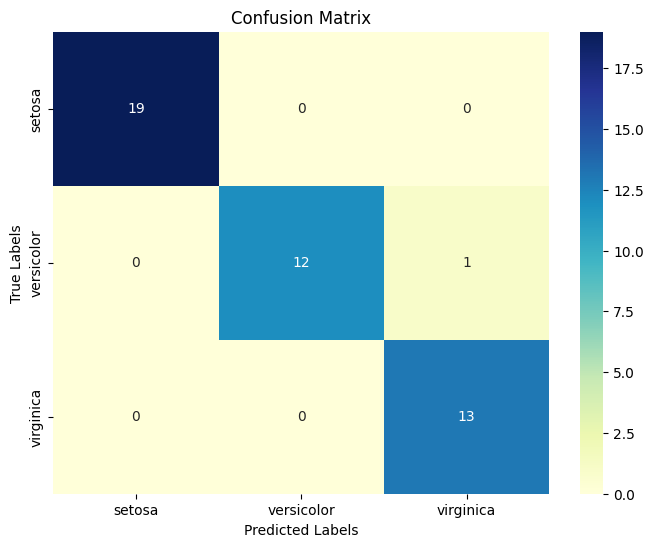

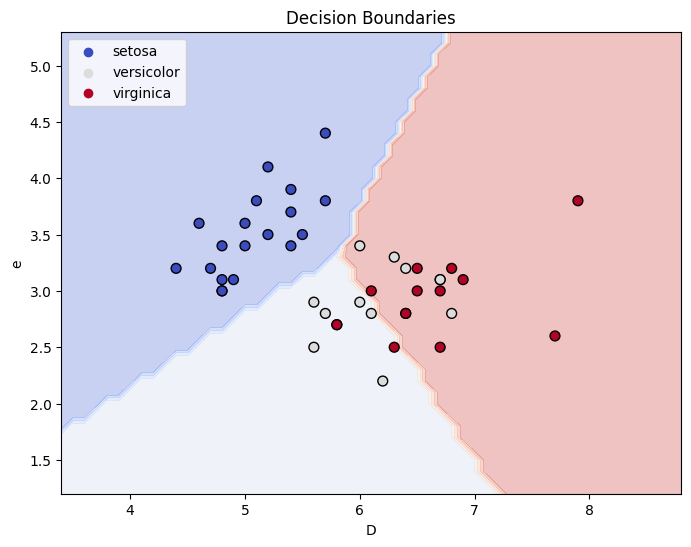

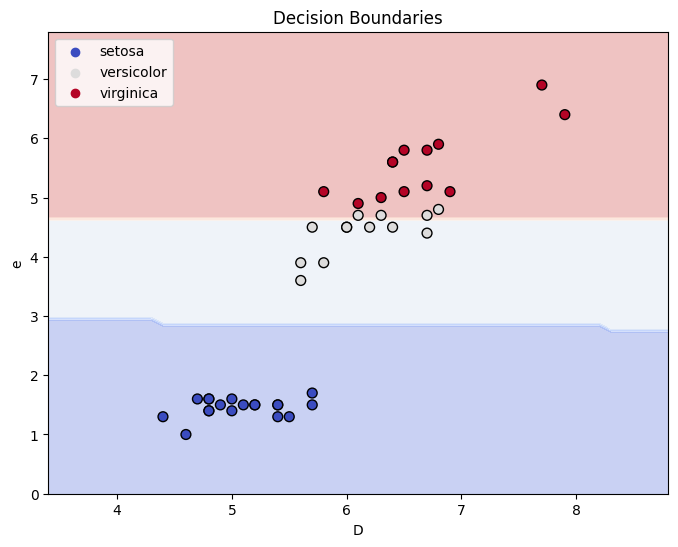

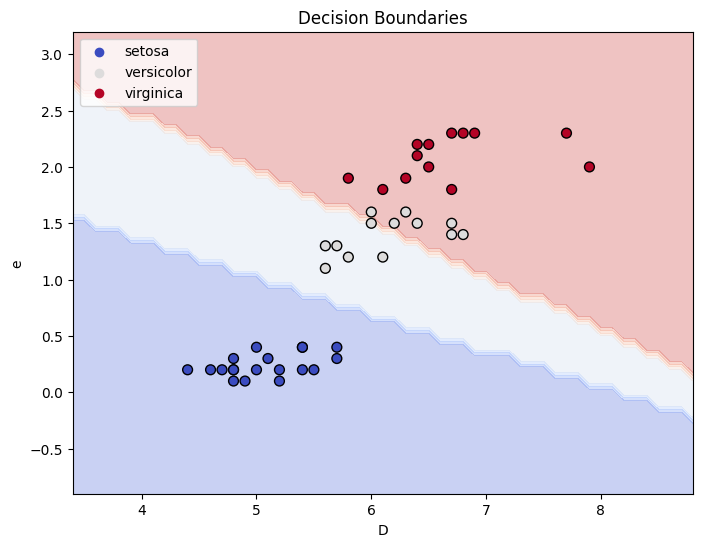

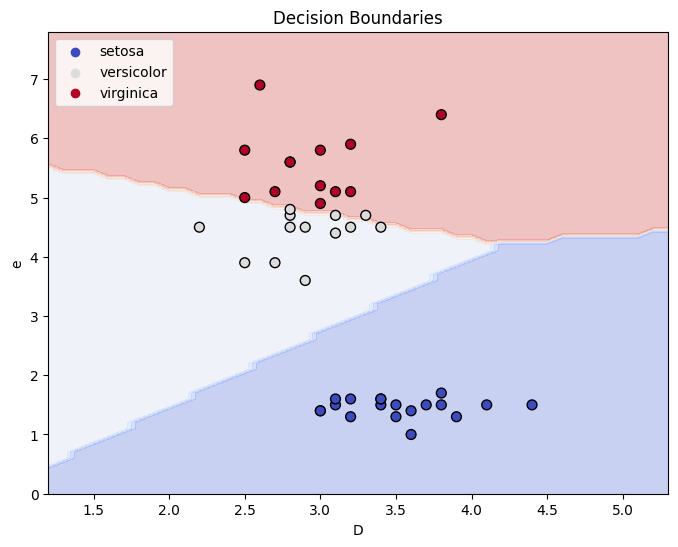

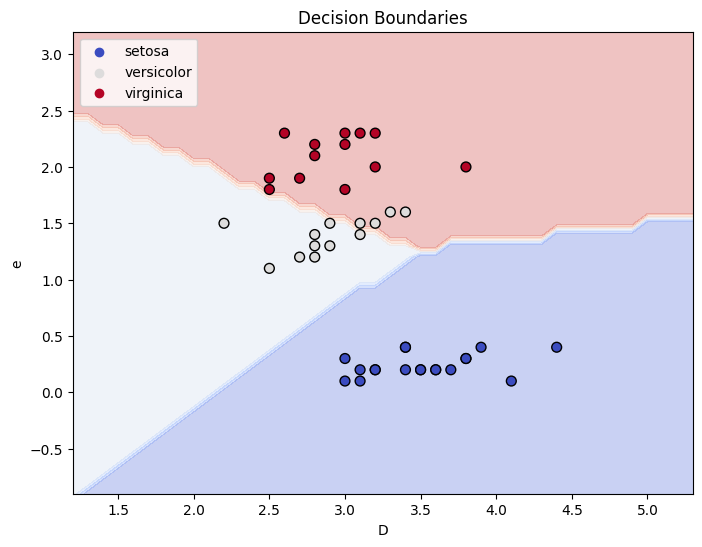

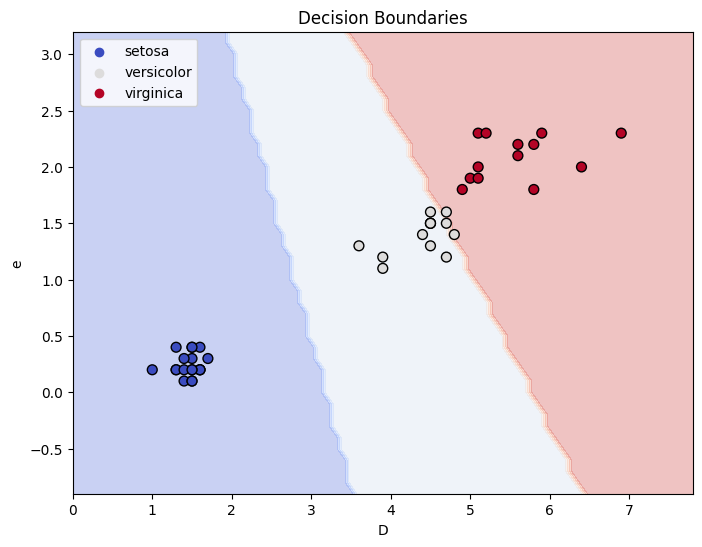

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

data = load_iris()
X, y = data.data, data.target
feature_names = data.feature_names

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Define hyperparameters for cross-validation
C_values = [0.1, 1, 10]
gamma_values = [0.01, 0.1, 1]
best_params, best_score = cross_validate(X_train, y_train, kernel="linear", C_values=C_values, gamma_values=gamma_values)

print("Best Hyperparameters:", best_params)
print("Best Cross-Validation Score:", best_score)

final_model = MultiClassSVM(C=best_params["C"], kernel="linear", gamma=best_params["gamma"])
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

# Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="YlGnBu", xticklabels=data.target_names, yticklabels=data.target_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Plot Decision Boundaries for each pair of features
def plot_decision_boundaries_for_features(model, X, y, feature_pair, feature_names, title="Decision Boundaries"):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    # Predict over the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")
    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap="coolwarm", edgecolor="k", s=50)

    for i, class_name in enumerate(data.target_names):
        plt.scatter([], [], color=scatter.cmap(scatter.norm(i)), label=class_name)
    plt.legend(loc="upper left")

    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(title)
    plt.show()

# Loop over each unique pair of features
num_features = X.shape[1]
for i in range(num_features):
    for j in range(i + 1, num_features):
        X_train_pair = X_train[:, [i, j]]
        X_test_pair = X_test[:, [i, j]]

        pair_model = MultiClassSVM(C=best_params["C"], kernel="linear", gamma=best_params["gamma"])
        pair_model.fit(X_train_pair, y_train)

        feature_pair_names = [feature_names[i], feature_names[j]]
        title = f"Decision Boundaries ({feature_pair_names[0]} vs {feature_pair_names[1]})"
        plot_decision_boundaries_for_features(pair_model, X_test_pair, y_test, feature_pair_names, title)
